In [3]:
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data, wb
import datetime
import pickle
import os
from scipy import fftpack
import seaborn as sns
from matplotlib.font_manager import FontProperties

In [5]:
plt.style.use('seaborn-notebook')
#sns.set_style("whitegrid")
#sns.set_style("ticks")
sns.set_style("dark")

plt.rc('font', family='Noto Sans Korean')

In [6]:
plt.style.available

[u'seaborn-darkgrid',
 u'seaborn-notebook',
 u'classic',
 u'seaborn-ticks',
 u'grayscale',
 u'bmh',
 u'seaborn-talk',
 u'dark_background',
 u'ggplot',
 u'fivethirtyeight',
 u'seaborn-colorblind',
 u'seaborn-deep',
 u'seaborn-whitegrid',
 u'seaborn-bright',
 u'seaborn-poster',
 u'seaborn-muted',
 u'seaborn-paper',
 u'seaborn-white',
 u'seaborn-pastel',
 u'seaborn-dark',
 u'seaborn-dark-palette']

# 채권거래현황

In [7]:
# index_col 로 지정된 열은 Index 형식, datetime 형식으로 변경해야한다.
df=pd.read_excel('data/채권거래현황-v2.xls', thousands=',', index_col=0)
df_bond=df[df[u'구분']==u'거래대금']

df_bond.index=pd.to_datetime(df_bond.index)
#df_bond.sort_index()
#df_bond.head()
df_bond.index

DatetimeIndex(['2016-07-22', '2016-07-21', '2016-07-20', '2016-07-19',
               '2016-07-18', '2016-07-15', '2016-07-14', '2016-07-13',
               '2016-07-12', '2016-07-11',
               ...
               '2011-01-14', '2011-01-13', '2011-01-12', '2011-01-11',
               '2011-01-10', '2011-01-07', '2011-01-06', '2011-01-05',
               '2011-01-04', '2011-01-03'],
              dtype='datetime64[ns]', name=u'거래일', length=1378, freq=None)

# 채권 금리(최종호가 수익률)

In [8]:
df=pd.read_excel('data/최종호가수익률-v2.xls', thousands=',', index_col=0)

df.columns=map(lambda x : x.replace('\n', ''), df.columns)
df.index=pd.to_datetime(df.index)
df=df.sort_index()
df_bond_interest=df
df_bond_interest.head()

,국고채권(3년),국고채권(5년),국고채권(10년),회사채(무보증3년)AA-,회사채(무보증3년)BBB-,CP(91일)
일자,,,,,,
2011-01-03,3.50,4.15,4.57,4.32,10.31,3.01
2011-01-04,3.50,4.18,4.59,4.32,10.32,3.01
2011-01-05,3.50,4.20,4.63,4.32,10.33,3.01
2011-01-06,3.58,4.29,4.70,4.39,10.40,3.01
2011-01-07,3.59,4.30,4.71,4.39,10.41,3.00


# Fetch KOSPI from Google

In [9]:
start = datetime.datetime(2011, 1, 1)
end = datetime.datetime(2016, 7, 11)

In [10]:
google_data_name='KRX:KOSPI100'

# Open 	High 	Low 	Close 	Volume
datafilename='data/%s-20110101-20160711.pkl' % google_data_name
df_kospi=None
if os.path.isfile(datafilename):
    fd=open(datafilename)
    df_kospi=pickle.load(fd)
    fd.close()
else:
    df_kospi=data.DataReader(google_data_name, 'google', start, end)
    df_kospi.sort_index()
    output = open(datafilename, 'wb')
    pickle.dump(df_kospi, output)
    output.close()

# Check data

In [11]:
sdate=datetime.date(year=2015,month=1,day=1)
edate=datetime.date(year=2016,month=1,day=1)

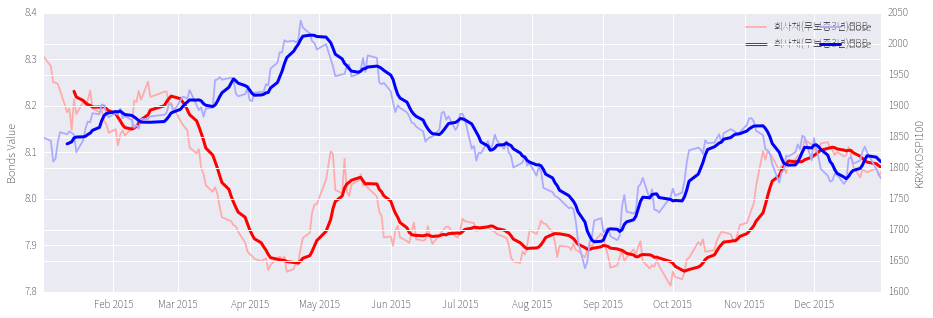

,합계,회사채(무보증3년)BBB-,Close
합계,1.000000,0.015409,0.220196
회사채(무보증3년)BBB-,0.015409,1.000000,0.172902
Close,0.220196,0.172902,1.000000


In [12]:
col0=u'합계'
col1=u'회사채(무보증3년)BBB-'
col2=u'회사채(무보증3년)AA-'
col3='Close'
df=pd.concat([df_bond[col0], df_bond_interest[col1], df_kospi[col3]], axis=1, join_axes=[df_bond.index])

df=df.dropna().sort_index()
df_merged=df.ix[sdate:edate]
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.grid(True)
ax1.plot(df_merged[col1], color='#ffaaaa')
ax1.set_ylabel('Bonds Value')
ax1.plot(df_merged[col1].rolling(window=10).mean(), color='r', linewidth=3)

ax1.legend()
ax2=ax1.twinx()
ax2.grid(True)
ax2.plot(df_merged[col3], color='#aaaaff')
ax2.plot(df_merged[col3].rolling(window=7).mean(), color='b', linewidth=3)
ax2.set_ylabel(google_data_name)
ax2.legend()
plt.show()
#abs(df_merged.corr('pearson')) >  0.2
df_merged.corr('pearson')

## BBB- 는 AA- 대비 어떻게 변해왔나?

count    1378.000000
mean        5.788503
std         0.182067
min         5.310000
25%         5.690000
50%         5.780000
75%         5.940000
max         6.090000
dtype: float64


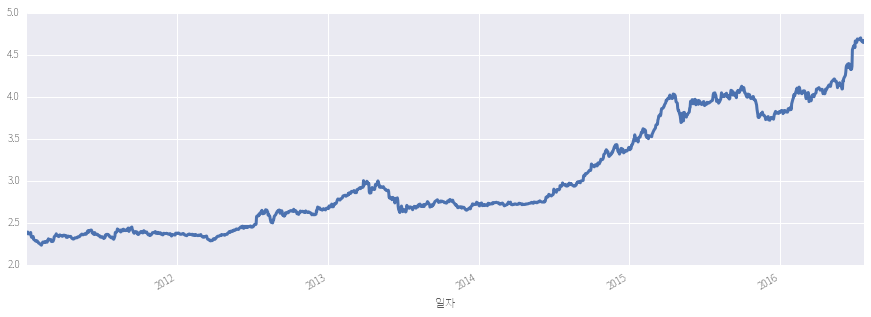

In [13]:
col1=u'회사채(무보증3년)BBB-'
col2=u'회사채(무보증3년)AA-'

df=df_bond_interest[col1]-df_bond_interest[col2]
print df.describe()

df=df_bond_interest[col1]/df_bond_interest[col2]
df.plot(figsize=(15,5), linewidth=3, grid=True)

2012년에 2.4배 정도되던 금리가 2016년엔 4.5배 이상으로 뛰었다.

  * Q1 : 뭐가 오른거야?
  

## Q1

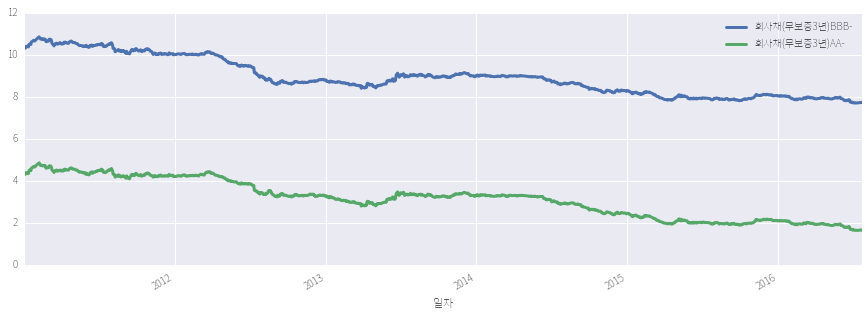

In [14]:
df=df_bond_interest[[col1, col2]]
df.plot(figsize=(15,5), linewidth=3, grid=True)

금리차는 일정하나 분모가 작아져서 ...

## 분석

채권가격과 KOSPI 종가는 minus correlation

## Seasonal periodicity

Alias 	Description
B 	business day frequency
C 	custom business day frequency (experimental)
D 	calendar day frequency
W 	weekly frequency
M 	month end frequency
BM 	business month end frequency
CBM 	custom business month end frequency
MS 	month start frequency
BMS 	business month start frequency
CBMS 	custom business month start frequency
Q 	quarter end frequency
BQ 	business quarter endfrequency
QS 	quarter start frequency
BQS 	business quarter start frequency
A 	year end frequency
BA 	business year end frequency
AS 	year start frequency
BAS 	business year start frequency
BH 	business hour frequency
H 	hourly frequency
T, min 	minutely frequency
S 	secondly frequency
L, ms 	milliseconds
U, us 	microseconds
N 	nanoseconds

/home/k/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]
/home/k/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


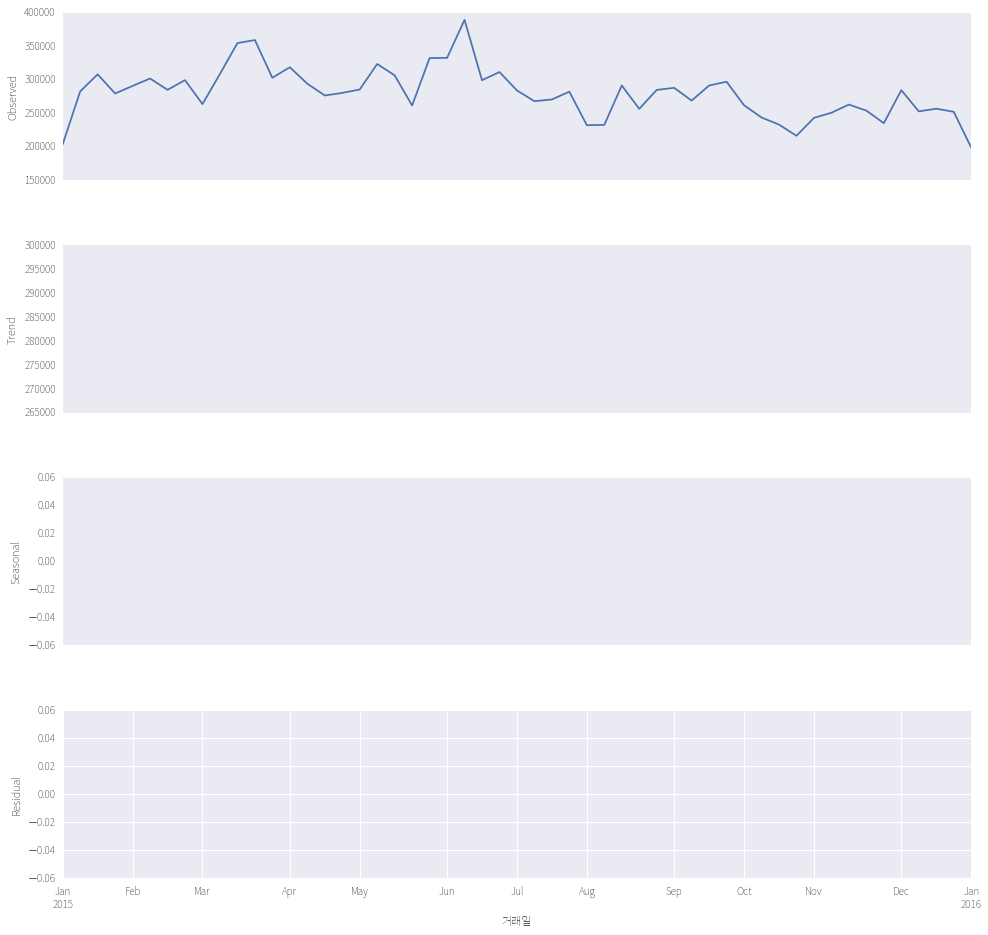

In [15]:
import statsmodels.api as sm

df_season=df_merged
df_season=df_season.drop('Close', axis=1)

# http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases
df_season = df_season.resample('W').mean()
df_season.head()

flow=df_season[u'합계']
res = sm.tsa.seasonal_decompose(flow)  

#fig,ax = plt.subplots(1,1, figsize=(15,5))  
plt.figure(figsize=(15, 5))
fig = res.plot()
ax = fig.gca()
ax.grid(True)
fig.show()
fig.set_size_inches(15, 15)

Series([], Freq: W-SUN, Name: 합계, dtype: float64)


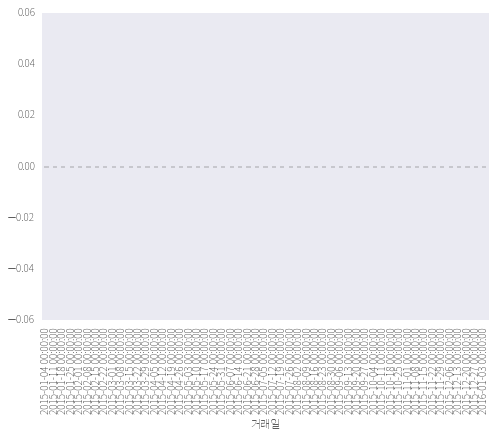

In [16]:
seasonal = res.seasonal
print seasonal[abs(seasonal) > 30000]
seasonal.plot(kind='bar')

## DCT

In [214]:
#coeff=fftpack.dct(df_merged[u'합계'], norm='ortho')
#plt.figure(figsize=(15, 5))
#plt.plot(coeff)
#plt.hist(np.log10(np.abs(coeff)), bins=100, color='#348ABD', alpha=.3, histtype='stepfilled')
